In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_selection import RFE


In [3]:
filePath = "E:\\Cntt_Class\\PTDLL\\BTL_PTDLL_N10_CarPricePrediction\\dataset.csv"
dataFrame = pd.read_csv(filePath)
dataFrame.head(5)

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [4]:
# Xóa Cột New_Price
dataFrame = dataFrame.drop(columns=['New_Price'])
# Xóa hàng có giá trị NULL
dataFrame = dataFrame.dropna()
# Tạo Index
dataFrame = dataFrame.rename(columns={'Unnamed: 0': 'ID'})

# Trích xuất dữ liệu số từ các cột có dữ liệu số và ký tự
dataFrame['Engine_Number'] = dataFrame['Engine'].str.extract(r'(\d+)')
dataFrame['Engine_Number'] = pd.to_numeric(dataFrame['Engine_Number'], errors='coerce')

dataFrame['Power_Number'] = dataFrame['Power'].str.extract(r'(\d+\.*\d*)')
dataFrame['Power_Number'] = pd.to_numeric(dataFrame['Power_Number'], errors='coerce')

# Điền giá trị khuyết cho cột Power_Number
dataFrame = dataFrame.fillna(dataFrame['Power_Number'].mean())

# Tạo 1 cột lưu lại đơn vị của cột Mileage
dataFrame['Mileage_unit'] = dataFrame['Mileage'].apply(lambda x: 'kmpl' if 'kmpl' in str(x) else 'km/kg')
# Chuyển đơn vị km/kg sang kmpl của cột Mileage
dataFrame['Mileage'] = dataFrame['Mileage'].apply(lambda x: float(x.split()[0]) * 2.352 if 'km/kg' in x else float(x.split()[0]))

# Chuyển các cột phi số sang số để phân tích và dự báo
fuel_type_mapping = {'CNG': 1, 'Diesel': 2, 'Petrol': 3, 'LPG': 4}
dataFrame['Fuel_Type'] = dataFrame['Fuel_Type'].map(fuel_type_mapping)
transmission_type_mapping = {'Manual': 1, 'Automatic': 2}
dataFrame['Transmission'] = dataFrame['Transmission'].map(transmission_type_mapping)
owner_type_mapping = {'First': 1, 'Second': 2, 'Third': 3, 'Fourth & Above': 4}
dataFrame['Owner_Type'] = dataFrame['Owner_Type'].map(owner_type_mapping)

# Bỏ đi các cột cũ
dataFrame = dataFrame.drop(columns = ['Mileage_unit', 'Power', 'Engine', 'Location', 'Name'])

# Bỏ đi các cột bị lặp
dataFrame = dataFrame.drop_duplicates(keep='first')

dataFrame.to_csv('E:\\Cntt_Class\\PTDLL\\BTL_PTDLL_N10_CarPricePrediction\\data_ok.csv', sep=',' )

In [4]:
#Kiểm tra giá trị null và giá trị lặp các cột
missing_data = dataFrame.isnull().sum()
duplicate_data = dataFrame.duplicated()

print("Số liệu thiếu trong mỗi cột:")
print(missing_data)

print("\nSố liệu trùng lặp:")
print(duplicate_data.sum())

Số liệu thiếu trong mỗi cột:
ID                   0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Seats                0
Price                0
Engine_Number        0
Power_Number         0
dtype: int64

Số liệu trùng lặp:
0


TOM LUOC DU LIEU

In [8]:
dataFrame.describe()

,ID,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Seats,Price,Engine_Number,Power_Number
count,5975.00000,5975.000000,5.975000e+03,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000
mean,3008.80887,2013.386778,5.867431e+04,2.448201,1.286025,1.200669,18.545355,5.278828,9.501647,1621.606695,113.276894
std,1739.30056,3.247238,9.155851e+04,0.519090,0.451939,0.453458,6.243064,0.808959,11.205736,601.036987,53.415373
min,0.00000,1998.000000,1.710000e+02,1.000000,1.000000,1.000000,0.000000,0.000000,0.440000,624.000000,34.200000
25%,1502.50000,2012.000000,3.390800e+04,2.000000,1.000000,1.000000,15.260000,5.000000,3.500000,1198.000000,77.000000
50%,3010.00000,2014.000000,5.300000e+04,2.000000,1.000000,1.000000,18.200000,5.000000,5.650000,1493.000000,98.600000
75%,4514.50000,2016.000000,7.300000e+04,3.000000,2.000000,1.000000,21.100000,5.000000,9.950000,1984.000000,138.100000
max,6018.00000,2019.000000,6.500000e+06,4.000000,2.000000,4.000000,78.886080,10.000000,160.000000,5998.000000,560.000000


CHUYEN DOI DU LIEU

In [5]:
from sklearn.preprocessing import MinMaxScaler
def min_max_nor(data, column):
    col = np.array(data[column]).reshape(-1, 1)
    scaler = MinMaxScaler()
    data[column] = scaler.fit_transform(col)
    return data

# Example usage:
df_minmax_nor = min_max_nor(dataFrame, 'Power_Number')
df_minmax_nor.head(10)
from sklearn.preprocessing import MinMaxScaler

def min_max_nor(data, column):
    col = np.array(data[column]).reshape(-1, 1)
    scaler = MinMaxScaler()
    data[column] = scaler.fit_transform(col)
    return data

# Example usage:
df_minmax_nor = min_max_nor(dataFrame, 'Mileage')
df_minmax_nor.to_csv('E:\\Cntt_Class\\PTDLL\\BTL_PTDLL_N10_CarPricePrediction\\data_normalization.csv', sep=',')

PHÂN TÍCH MÔ TẢ

Dữ liệu 15 dòng đầu sau tiền xử lý

In [11]:
df_minmax_nor.head(15)

,ID,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Seats,Price,Engine_Number,Power_Number
0,0,2010,72000,1,1,1,0.793083,5.0,1.75,998,0.045569
1,1,2015,41000,2,1,1,0.249347,5.0,12.50,1582,0.174971
2,2,2011,46000,3,1,1,0.230712,5.0,4.50,1199,0.103652
3,3,2012,87000,2,1,1,0.263291,7.0,6.00,1248,0.103766
4,4,2013,40670,2,2,2,0.192683,5.0,17.74,1968,0.202739
5,5,2012,75000,4,1,1,0.629100,5.0,2.35,814,0.039939
6,6,2013,86999,2,1,1,0.292574,5.0,3.50,1461,0.054964
7,7,2016,36000,2,2,1,0.144005,8.0,17.50,2755,0.261126
8,8,2013,64430,2,1,1,0.260375,5.0,5.20,1598,0.131989
9,9,2012,65932,2,1,2,0.282686,5.0,1.95,1248,0.075694


Bảng thống kê các đại lượng

Cột định lượng (Numeric columns): Year, Kilometers_Driven, Mileage, Seats, Price, Engine_Number, Power_Number

In [12]:
numeric_cols = ['Year', 'Kilometers_Driven', 'Mileage', 'Seats', 'Price', 'Engine_Number', 'Power_Number']
df_minmax_nor[numeric_cols].describe()

,Year,Kilometers_Driven,Mileage,Seats,Price,Engine_Number,Power_Number
count,5975.000000,5.975000e+03,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000
mean,2013.386778,5.867431e+04,0.235090,5.278828,9.501647,1621.606695,0.150393
std,3.247238,9.155851e+04,0.079140,0.808959,11.205736,601.036987,0.101589
min,1998.000000,1.710000e+02,0.000000,0.000000,0.440000,624.000000,0.000000
25%,2012.000000,3.390800e+04,0.193444,5.000000,3.500000,1198.000000,0.081400
50%,2014.000000,5.300000e+04,0.230712,5.000000,5.650000,1493.000000,0.122480
75%,2016.000000,7.300000e+04,0.267474,5.000000,9.950000,1984.000000,0.197604
max,2019.000000,6.500000e+06,1.000000,10.000000,160.000000,5998.000000,1.000000


Phân phối dữ liệu

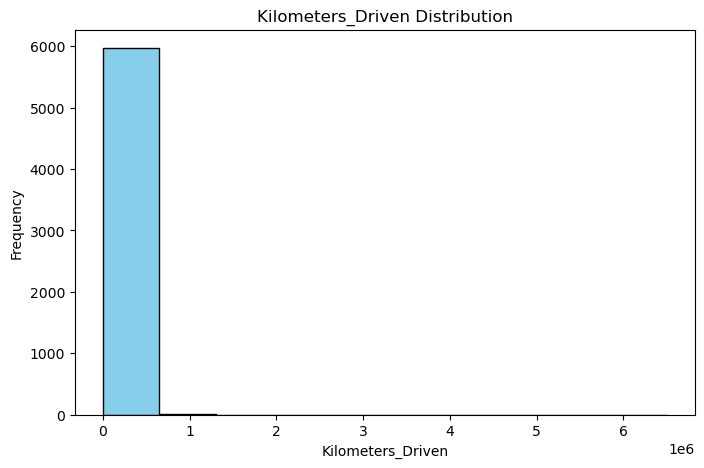

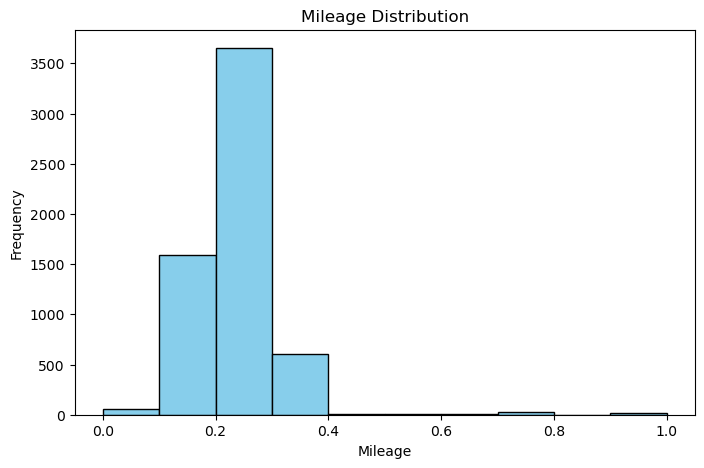

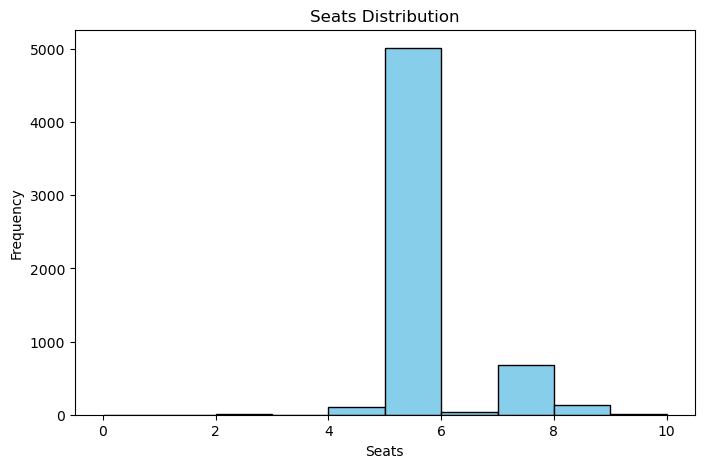

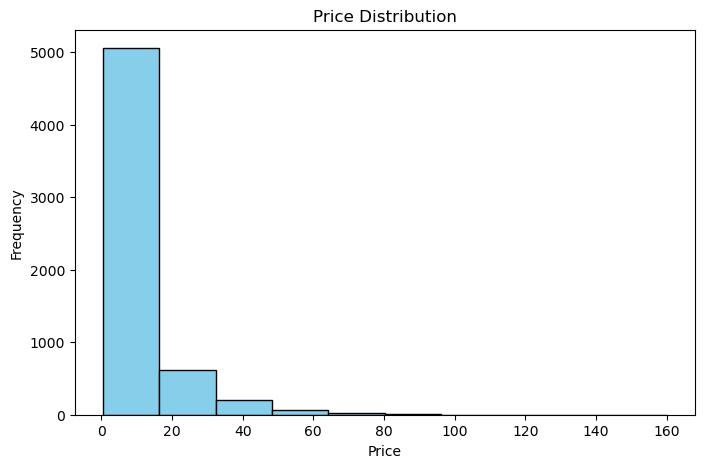

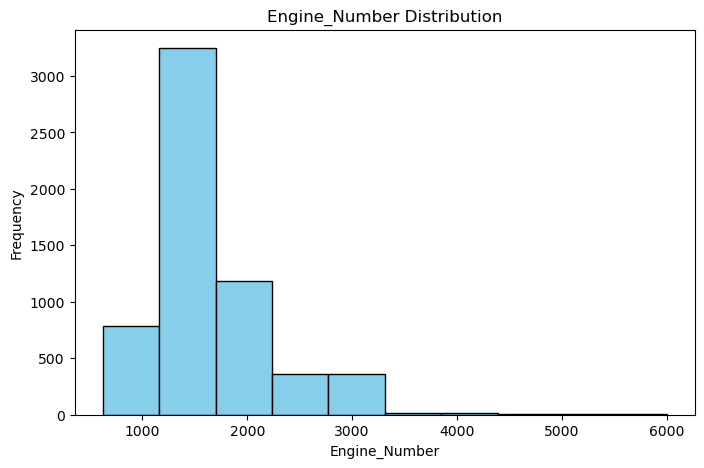

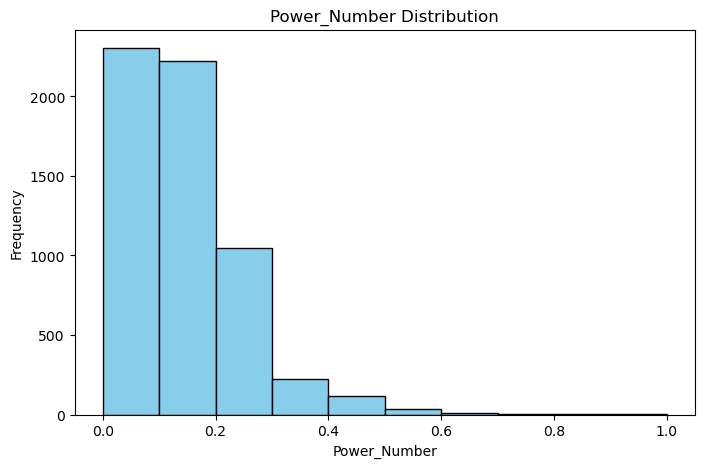

In [13]:
columns = ['Kilometers_Driven', 'Mileage', 'Seats', 'Price', 'Engine_Number', 'Power_Number']
for col in columns:
    plt.figure(figsize=(8, 5))
    df_minmax_nor[col].hist(bins=10, color='skyblue', edgecolor='black')
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()

Giá trị ngoại lệ và so sánh phân phối các cột.

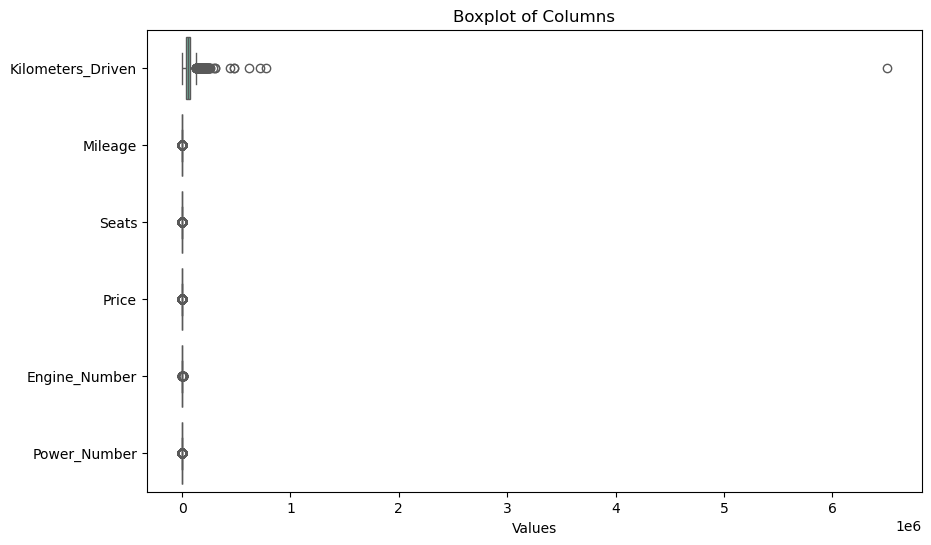

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_minmax_nor[columns], orient='h', palette='Set2')
plt.title('Boxplot of Columns')
plt.xlabel('Values')
plt.show()

Cột định tính (Categorical columns): Fuel_Type, Transmission, Owner_Type

In [15]:
categorical_cols = ['Fuel_Type', 'Transmission', 'Owner_Type']
for col in categorical_cols:
    print(f"\nThống kê cho cột {col}:")
    print(df_minmax_nor[col].value_counts(normalize=True) * 100)


Thống kê cho cột Fuel_Type:
Fuel_Type
2    53.472803
3    45.422594
1     0.937238
4     0.167364
Name: proportion, dtype: float64

Thống kê cho cột Transmission:
Transmission
1    71.39749
2    28.60251
Name: proportion, dtype: float64

Thống kê cho cột Owner_Type:
Owner_Type
1    82.058577
2    15.949791
3     1.857741
4     0.133891
Name: proportion, dtype: float64


Biểu đồ phân phối cột định tính

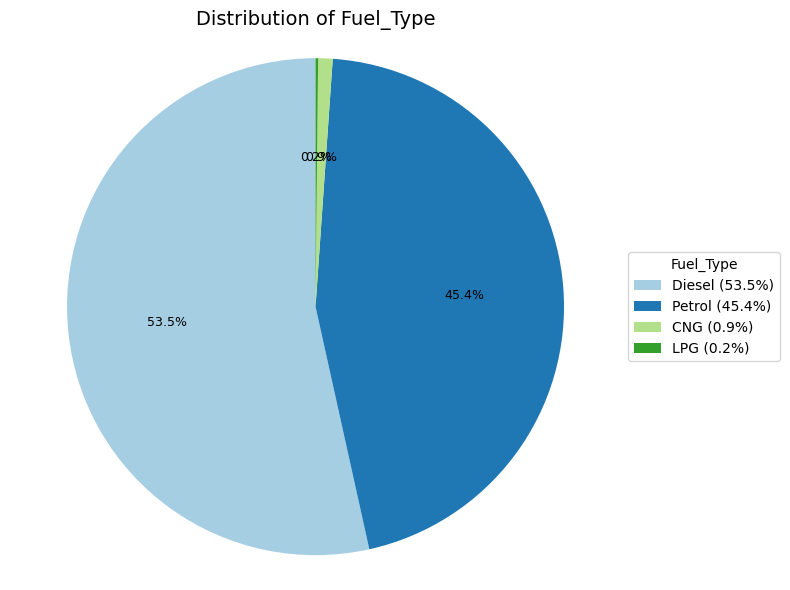

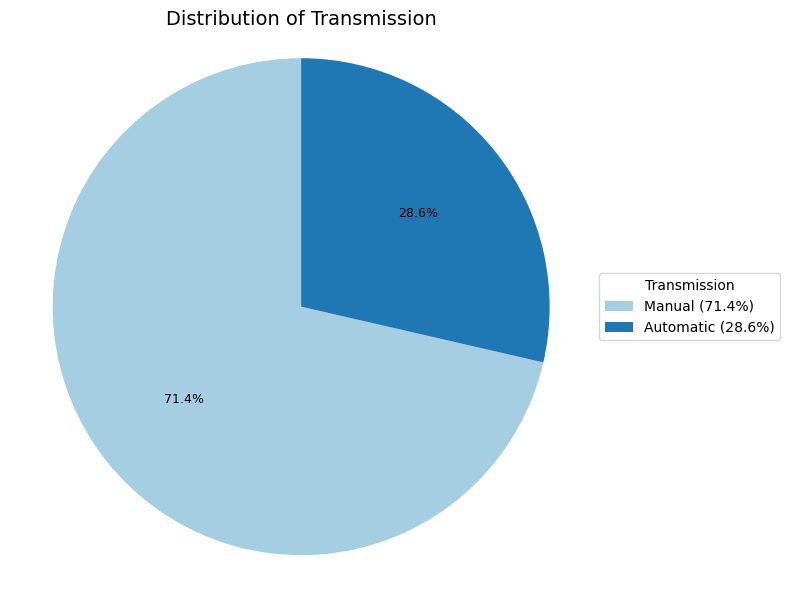

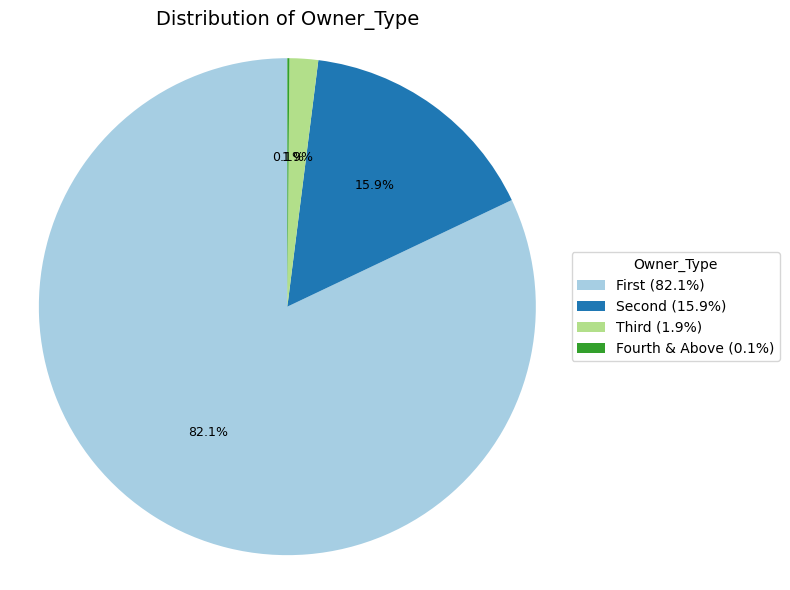

In [16]:
import matplotlib.pyplot as plt

# Tạo từ điển ánh xạ đúng
mappings = {
    'Fuel_Type': {1: 'CNG', 2: 'Diesel', 3: 'Petrol', 4: 'LPG'},  # Sửa ánh xạ đúng theo mapping ban đầu
    'Transmission': {1: 'Manual', 2: 'Automatic'},
    'Owner_Type': {1: 'First', 2: 'Second', 3: 'Third', 4: 'Fourth & Above'}  # Thêm ánh xạ cho 'Fourth & Above'
}

# Danh sách các cột phân loại
categorical_cols = ['Fuel_Type', 'Transmission', 'Owner_Type']

# Vẽ biểu đồ Pie Chart với nhãn được bố trí hợp lý
for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    
    # Ánh xạ giá trị cột sang nhãn
    mapped_values = dataFrame[col].map(mappings[col])  # Dùng cột `dataFrame` với ánh xạ đúng
    values = mapped_values.value_counts()  # Đếm số lượng từng loại
    labels = values.index.tolist()  # Nhãn cho biểu đồ
    sizes = values.values  # Tần suất
    
    # Tính phần trăm cho mỗi phần và tạo nhãn với phần trăm
    percentages = [f"{label} ({size/values.sum()*100:.1f}%)" for label, size in zip(labels, sizes)]
    
    # Vẽ Pie Chart
    wedges, texts, autotexts = plt.pie(
        sizes,
        labels=None,
        autopct='%1.1f%%',  # Hiển thị phần trăm trong biểu đồ
        startangle=90,
        colors=plt.cm.Paired.colors,
        labeldistance=1.1  # Tăng khoảng cách nhãn từ tâm
    )

    # Tùy chỉnh hiển thị nhãn
    for text in texts:
        text.set_fontsize(10)  # Kích thước nhãn bên ngoài
    for autotext in autotexts:
        autotext.set_fontsize(9)  # Kích thước nhãn phần trăm bên trong
    
    # Thêm chú thích (Legend) bên ngoài với phần trăm
    plt.legend(wedges, percentages, title=col, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)
    
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.axis('equal')  # Đảm bảo biểu đồ tròn
    plt.tight_layout()  # Tự động căn chỉnh để không bị tràn
    plt.show()


Phân bổ các hãng xe và số lượng bán tương ứng

Text(0, 0.5, 'Count of cars')

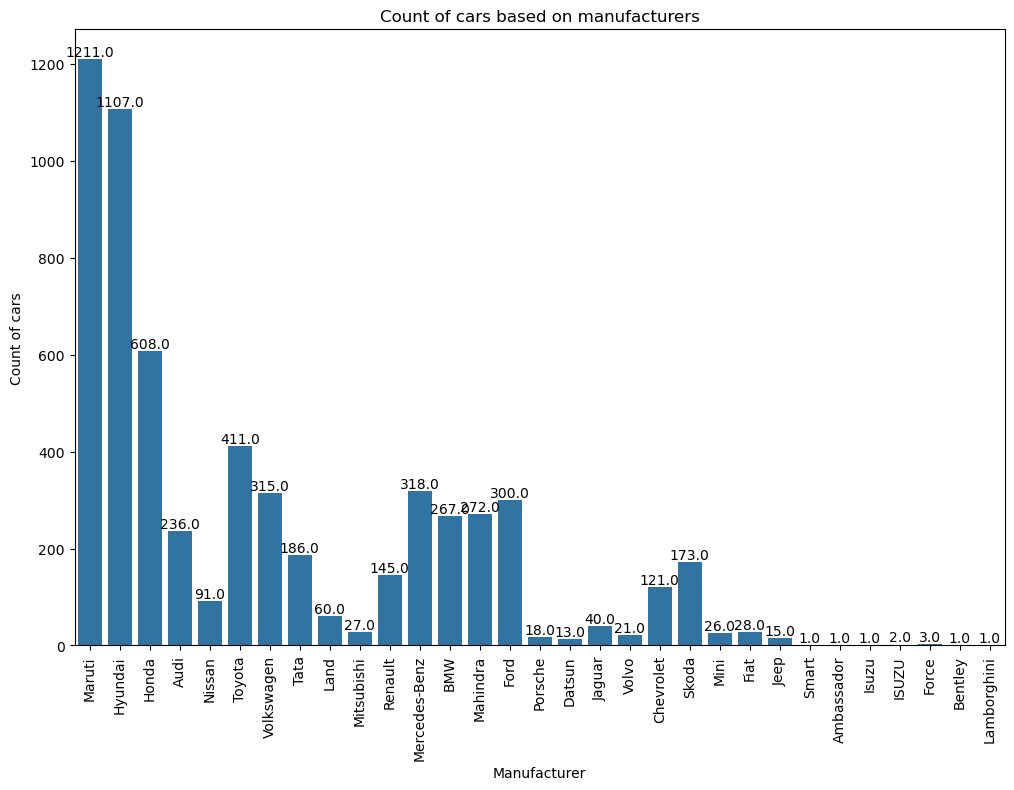

In [17]:
dataFrame2 = pd.read_csv(filePath)
cl = dataFrame2["Name"].str.split(" ", expand = True)
dataFrame2["Manufacturer"] = cl[0]
plt.figure(figsize = (12, 8))
plot = sns.countplot(x = 'Manufacturer', data = dataFrame2)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Count of cars based on manufacturers")
plt.xlabel("Manufacturer")
plt.ylabel("Count of cars")

Biểu đồ về sự thay đổi giá xe theo từng năm

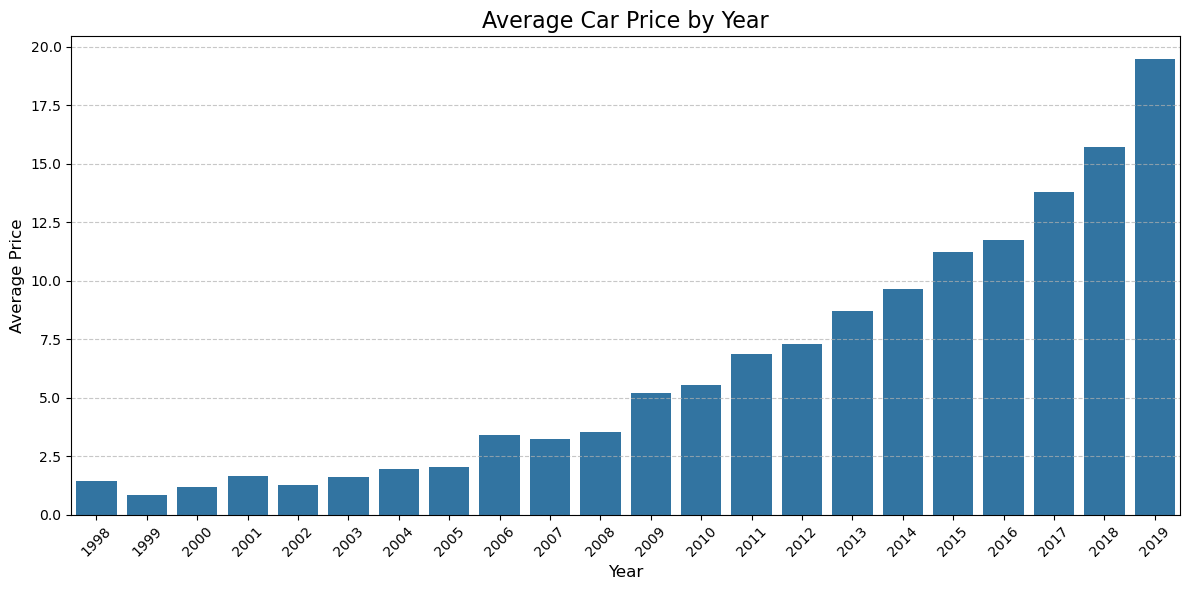

In [18]:
# Tính giá trị trung bình của 'Price' theo 'Year'
average_price_per_year = df_minmax_nor.groupby('Year')['Price'].mean().reset_index()

# Vẽ biểu đồ cột (Vertical Bar Chart)
plt.figure(figsize=(12, 6))
sns.barplot(data=average_price_per_year, x='Year', y='Price', legend=False)

# Tùy chỉnh biểu đồ
plt.title('Average Car Price by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

Biểu đồ phân bổ giá xe theo phương thức sản xuất

C:\Users\xuanv\AppData\Local\Temp\ipykernel_8332\840681704.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_minmax_nor, x='Transmission', y='Price', order=sorted_transmissions, palette='Set2')


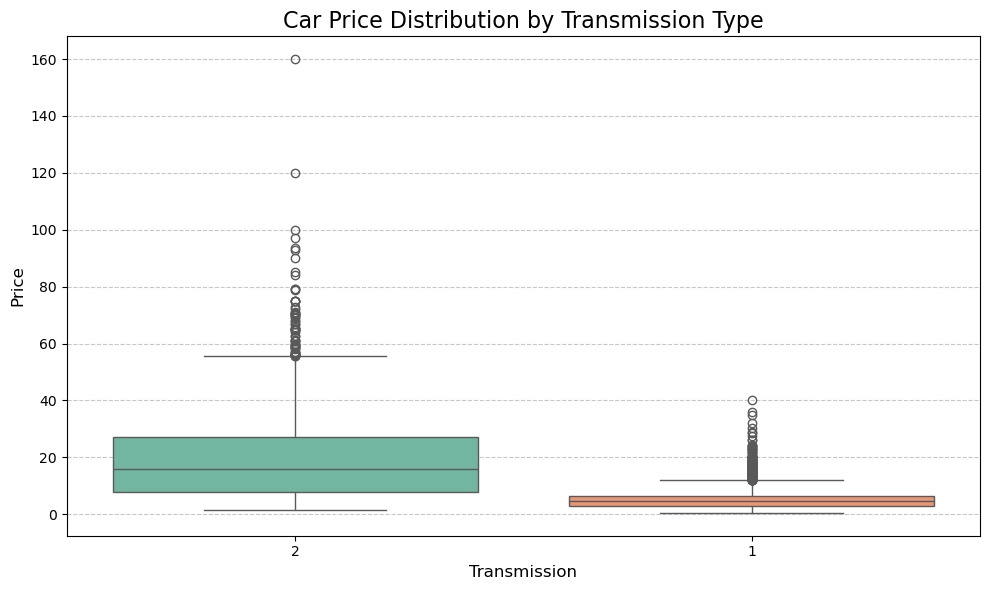

In [19]:
transmission_price_mean = (
    df_minmax_nor.groupby('Transmission')['Price'].mean().sort_values(ascending=False)
)
# Sắp xếp thứ tự trên trục x theo giá trị trung bình đã tính
sorted_transmissions = transmission_price_mean.index

# Vẽ biểu đồ hộp (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_minmax_nor, x='Transmission', y='Price', order=sorted_transmissions, palette='Set2')

# Tùy chỉnh biểu đồ
plt.title('Car Price Distribution by Transmission Type', fontsize=16)
plt.xlabel('Transmission', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

Biểu đồ phân bổ trung bình giá xe theo từng năm đối
với mỗi hãng xe.

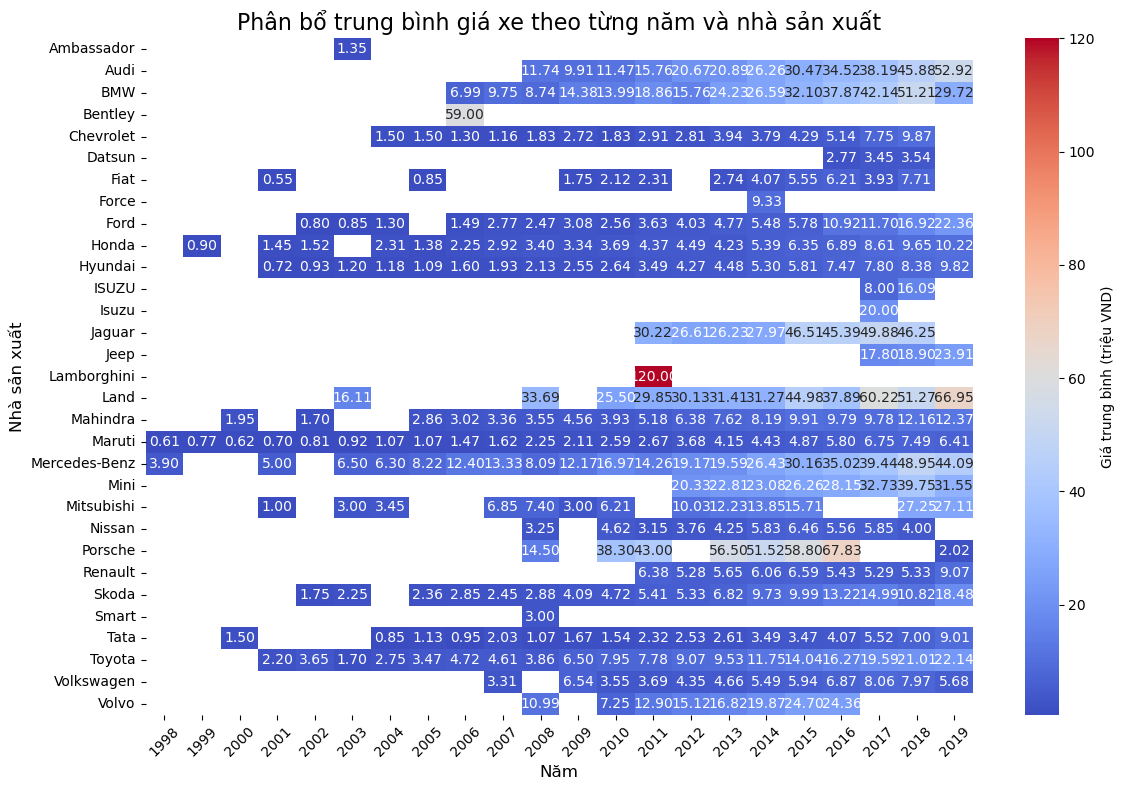

In [20]:

average_price_by_year_manufacturer = dataFrame2.groupby(['Year', 'Manufacturer'])['Price'].mean().reset_index()

# Chuyển đổi dữ liệu sang dạng pivot (Year là cột, Manufacturer là hàng)
pivot_table = average_price_by_year_manufacturer.pivot(index='Manufacturer', columns='Year', values='Price')

# Vẽ biểu đồ Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Giá trung bình (triệu VND)'})
plt.title('Phân bổ trung bình giá xe theo từng năm và nhà sản xuất', fontsize=16)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Nhà sản xuất', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Biểu đồ tương quan giữa các thuộc tính

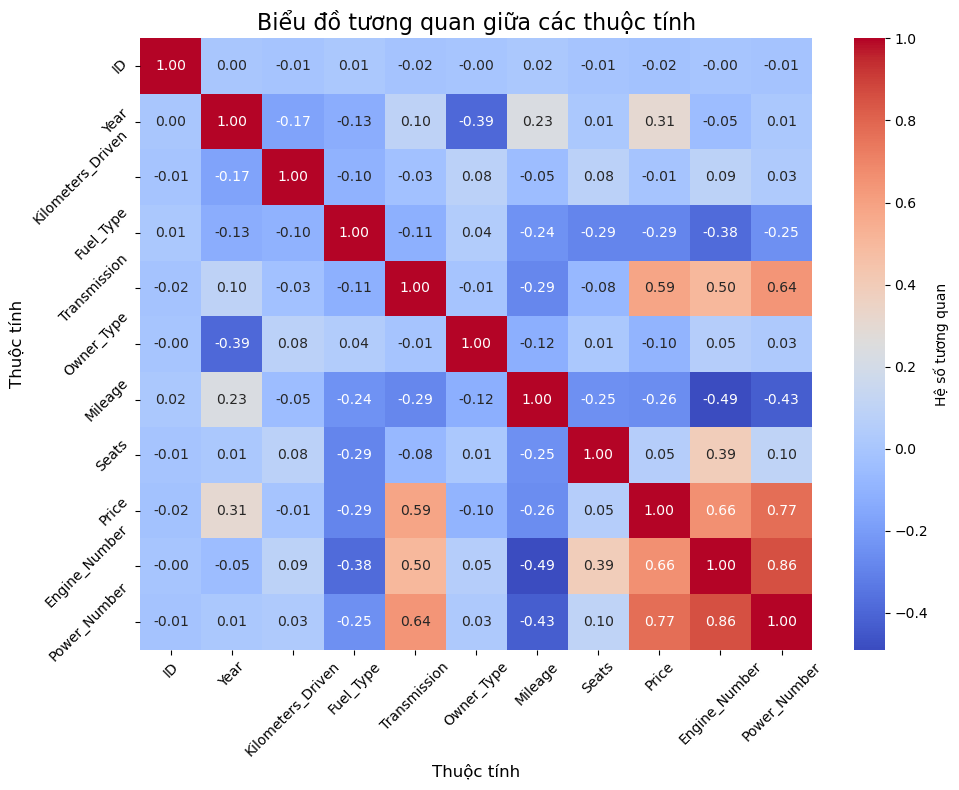

In [21]:
correlation_matrix = df_minmax_nor.corr()
# Vẽ biểu đồ Heatmap biểu diễn tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Hệ số tương quan'})
plt.title('Biểu đồ tương quan giữa các thuộc tính', fontsize=16)
plt.xlabel('Thuộc tính', fontsize=12)
plt.ylabel('Thuộc tính', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

Phân tích dựa trên phương pháp hồi quy tuyến tính

In [6]:
from sklearn.model_selection import KFold, train_test_split, cross_val_score
import joblib
# Tạo data
X = df_minmax_nor[['Year', 'Kilometers_Driven', 'Mileage', 'Seats', 'Engine_Number', 'Power_Number', 'Fuel_Type', 'Transmission', 'Owner_Type']]
Y = df_minmax_nor['Price']

# Chia tập train và test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

# Tạo model
model = LinearRegression()

# Train model
model.fit(X_train, Y_train)

# Kiểm tra độ chính xác
Y_pred = model.predict(X_test)
print(Y_pred.shape)

# Tính MSE và R-squared
mse = mean_squared_error(Y_test, Y_pred)  # Đo lường trung bình của bình phương sai số
r2 = r2_score(Y_test, Y_pred)

# In ra MSE và R-squared
print('Mean Squared Error:', mse)
print('R-squared:', r2)

print('R Square: ', model.score(X, Y))
print('Slope: ', model.coef_)
print('Intercept: ', model.intercept_)

# Sử dụng 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # KFold với 10 tập
cv_mse_scores = cross_val_score(model, X, Y, scoring='neg_mean_squared_error', cv=kf)
cv_r2_scores = cross_val_score(model, X, Y, scoring='r2', cv=kf)

# Chuyển đổi MSE sang giá trị dương
cv_mse_scores = -cv_mse_scores

# In kết quả cross-validation
print(f'Cross-Validation Mean Squared Error (10 folds): {np.mean(cv_mse_scores):.4f}')
print(f'Cross-Validation R-squared (10 folds): {np.mean(cv_r2_scores):.4f}')
# Sau khi huấn luyện mô hình
joblib.dump(model, "trained_model.pkl")

(4780, 9) (1195, 9) (4780,) (1195,)
(1195,)
Mean Squared Error: 72.71186745713628
R-squared: 0.5005254020877912
R Square:  0.667385263345307
Slope:  [ 9.01270083e-01 -1.97340093e-05 -5.55360446e+00 -9.45145038e-01
  1.78454935e-03  6.21866392e+01 -2.28776741e+00  2.80089971e+00
  3.77637020e-02]
Intercept:  -1808.028608043887
Cross-Validation Mean Squared Error (10 folds): 42.7907
Cross-Validation R-squared (10 folds): 0.6662


['trained_model.pkl']

In [7]:
import sys
from PyQt5.QtWidgets import (
    QApplication, QMainWindow, QGridLayout, QPushButton, QWidget,
    QLabel, QLineEdit, QGroupBox, QVBoxLayout, QSpacerItem, QSizePolicy
)
from PyQt5.QtGui import QFont, QIcon
from PyQt5.QtCore import Qt
from sklearn.linear_model import LinearRegression
import numpy as np

class PredictionApp(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Dự đoán giá xe")
        self.setGeometry(100, 100, 900, 700)

        self.model = joblib.load("trained_model.pkl")

        # Cài đặt font mặc định
        self.default_font = QFont("Arial", 12)
        self.setFont(self.default_font)

        # Tạo layout chính
        main_layout = QVBoxLayout()

        # Thêm tiêu đề và logo
        title_label = QLabel("🚗 Hệ Thống Dự Đoán Giá Xe")
        title_label.setFont(QFont("Arial", 20, QFont.Bold))
        title_label.setAlignment(Qt.AlignCenter)
        title_label.setStyleSheet("color: #2E86C1; margin-bottom: 20px;")
        main_layout.addWidget(title_label)

        # Tạo nhóm nhập liệu với card-style UI
        input_group = self.create_input_group()
        main_layout.addWidget(input_group)

        # Nút dự đoán
        self.predict_button = QPushButton("🔍 Dự đoán giá")
        self.predict_button.setStyleSheet("""
            QPushButton {
                background-color: #3498DB; 
                color: white; 
                font-size: 14px; 
                padding: 10px;
                border-radius: 5px;
            }
            QPushButton:hover {
                background-color: #2980B9;
            }
        """)
        self.predict_button.clicked.connect(self.predict_price)
        main_layout.addWidget(self.predict_button, alignment=Qt.AlignCenter)

        # Nhãn kết quả
        self.result_label = QLabel("💰 Dự đoán giá: ")
        self.result_label.setFont(QFont("Arial", 16))
        self.result_label.setAlignment(Qt.AlignCenter)
        self.result_label.setStyleSheet("color: #2ECC71; margin-top: 20px; border: 1px solid #D5D8DC; padding: 10px;")
        main_layout.addWidget(self.result_label)

        # Đặt layout chính
        container = QWidget()
        container.setLayout(main_layout)
        container.setStyleSheet("background-color: #F7F9F9; padding: 20px; border-radius: 10px;")
        self.setCentralWidget(container)

    def create_input_group(self):
        group_box = QGroupBox("Thông tin xe")
        group_box.setFont(QFont("Arial", 14))
        group_box.setStyleSheet("""
            QGroupBox {
                background-color: #F4F6F7; 
                border: 1px solid #D5D8DC; 
                border-radius: 10px; 
                margin-top: 20px;
            }
            QGroupBox::title {
                subcontrol-origin: margin; 
                subcontrol-position: top center; 
                padding: 5px 10px; 
                font-size: 16px; 
                color: #34495E;
            }
        """)

        layout = QGridLayout()
        self.inputs = {}

        labels = [
            "Year", "Kilometers Driven", "Mileage", "Seats",
            "Engine Number", "Power Number", "Fuel Type",
            "Transmission", "Owner Type"
        ]
        placeholders = [
            "Nhập Year", "Nhập Kilometers Driven", "Nhập Mileage",
            "Nhập Seats", "Nhập Engine Number", "Nhập Power Number",
            "Nhập Fuel Type (1: CNG, 2: Diesel, 3: Petrol, 4: LPG)",
            "Nhập Transmission (1: Manual, 2: Automatic)",
            "Nhập Owner Type (1: First, 2: Second, 3: Third, 4: Fourth & Above)"
        ]

        icons = [
            "calendar.png", "road.png", "fuel.png", "seat.png",
            "engine.png", "power.png", "fuel_type.png",
            "transmission.png", "owner.png"
        ]

        for i, (label, placeholder) in enumerate(zip(labels, placeholders)):
            lbl = QLabel(label)
            input_field = QLineEdit()
            input_field.setPlaceholderText(placeholder)
            input_field.setFixedHeight(40)
            input_field.setStyleSheet("""
                QLineEdit {
                    border: 1px solid #D5D8DC; 
                    border-radius: 5px; 
                    padding: 5px;
                    font-size: 14px;
                }
                QLineEdit:focus {
                    border-color: #3498DB;
                }
            """)
            layout.addWidget(lbl, i, 0)
            layout.addWidget(input_field, i, 1)
            self.inputs[label] = input_field

        group_box.setLayout(layout)
        return group_box

    def predict_price(self):
        try:
            # Lấy giá trị từ các trường nhập liệu
            input_data = []
            for label, field in self.inputs.items():
                value = field.text()
                if label in ["Year", "Kilometers Driven", "Engine Number", "Fuel Type", "Transmission", "Owner Type"]:
                    input_data.append(int(value))
                else:
                    input_data.append(float(value))

            new_X = np.array([input_data])

            # Sử dụng mô hình đã huấn luyện trước
            predicted_Y = self.model.predict(new_X)

            # Hiển thị kết quả dự đoán
            self.result_label.setText(f"💰 Dự đoán giá: {predicted_Y[0]:,.2f} VND")

        except ValueError:
            # Hiển thị lỗi nếu nhập liệu không hợp lệ
            self.result_label.setText("❌ Vui lòng nhập đúng dữ liệu.")


if __name__ == '__main__':
    app = QApplication(sys.argv)
    window = PredictionApp()
    window.show()
    sys.exit(app.exec_())


d:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  w

SystemExit: 0

C:\Users\xuanv\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
